In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as time
from skyfield.api import load, Topos
from skyfield.framelib import itrs
from astropy.time import Time

In [2]:
# Configuration parameters
Re = 6378  # Average Earth radius in km
Hs = 23222  # Approximate satellite altitude in km
Hion = 1000  # Altitude of the ionospheric layer in km

# Satellite orbital period in seconds
Triv = (14 * 60 * 60) + (5 * 60)  # 14 hours and 5 minutes converted to seconds
omega = 2 * np.pi / Triv  # Angular velocity of the satellite in rad/s

# Time step calculation based on angular precision
precision_grad = 0.4  # Desired angular precision in degrees
precision_rad = precision_grad * np.pi / 180  # Convert angular precision to radians
dt = precision_rad / omega  # Time step in seconds to achieve the desired angular precision
day_dt = dt / (60 * 60 * 24)  # Convert time step from seconds to days
DT = 1  # Number of days for collecting all data

# Print information about temporal precision and satellite frequency
print(f'''Temporal precision is calculated based on a satellite's angular variation of {precision_grad} degrees, 
assuming a spherical orbit and constant orbital speed''')
print(f'Satellite angular frequency (omega) in Hz: {omega} 1/s')
print(f'Temporal precision: {dt} seconds, in days: {day_dt}')


La precisione temporale è calcolata in base alla variazione di 0.4 gradi di un satellite, 
ammettendo un'orbita sferica e velocità costante in modulo
frequenza (omega) in Hz dei satelliti: 0.00012392870428362104 1/s
La precisione temporale: 56.33333333333333 secondi, in giorni: 0.0006520061728395062


# DATAFRAME CREATION WITH ORBITAL POSITIONS

In [8]:
# Load TLE data from files
file_tle = 'DATI\\tle_galileo.txt'
satellitesGAL = load.tle_file(file_tle)  # Load Galileo satellites from TLE file
print(f"Loaded {len(satellitesGAL)} satellites from Galileo TLE file.")

file_tle = 'DATI\\tle_gps.txt'
satellitesGPS = load.tle_file(file_tle)  # Load GPS satellites from TLE file
print(f"Loaded {len(satellitesGPS)} satellites from GPS TLE file.")

# Create dictionaries to access satellites by name
satellite_by_nameGAL = {sat.name: sat for sat in satellitesGAL}  # Galileo satellites by name
satellite_by_nameGPS = {sat.name: sat for sat in satellitesGPS}  # GPS satellites by name

# Define the time range
ts = load.timescale()  # Load Skyfield timescale
start_time = ts.utc(2023, 2, 25, 0, 0, 0)  # Start of the 1-day period
end_time = start_time + DT   # End of the period (DT is in days)

# Generate an array of time steps
times = []
current_time = start_time
while current_time.tt < end_time.tt:  # Loop until end_time
    times.append(current_time)  # Append current time to the array
    current_time = current_time + dt / (24 * 3600)  # Increment time by dt (converted from seconds to days for Skyfield)

print(len(times))  # Print total number of time steps

# Initialize a dictionary to store satellite positions
satellite_data = {'Time': []}

# Add keys for each Galileo satellite
for sat in satellitesGAL:
    satellite_data[sat.name] = []  

# Add keys for each GPS satellite
for sat in satellitesGPS:
    satellite_data[sat.name] = []  

# Calculate satellite positions at each time step
for i, t in enumerate(times):
    if i % 200 == 0:
        print(f'Positions calculated up to time {t.utc_iso()}  iteration {i}')  # Progress indicator every 200 steps
    
    satellite_data['Time'].append(t.utc_iso())  # Store time in ISO format
    
    for satellite in satellitesGAL + satellitesGPS:  # Loop over all satellites
        geocentric = satellite.at(t)  # Get geocentric position at time t
        position = geocentric.position.km  # Position in km (ECI coordinates)
        
        # Convert geocentric position to ECEF coordinates using Skyfield
        ecef_position = geocentric.frame_xyz(itrs).km  
        
        # Append ECEF position [x, y, z] to the corresponding satellite list
        satellite_data[satellite.name].append(list(ecef_position))  


Loaded 30 satellites from Galileo TLE file.
Loaded 31 satellites from GPS TLE file.
1534
Positions calculated up to time 2023-02-25T00:00:00Z  iteration 0
Positions calculated up to time 2023-02-25T03:07:47Z  iteration 200
Positions calculated up to time 2023-02-25T06:15:33Z  iteration 400
Positions calculated up to time 2023-02-25T09:23:20Z  iteration 600
Positions calculated up to time 2023-02-25T12:31:07Z  iteration 800
Positions calculated up to time 2023-02-25T15:38:53Z  iteration 1000
Positions calculated up to time 2023-02-25T18:46:40Z  iteration 1200
Positions calculated up to time 2023-02-25T21:54:27Z  iteration 1400


In [4]:
# Create a DataFrame from the satellite data dictionary
df = pd.DataFrame(satellite_data)  

# Extract the satellite names (all columns except the first 'Time' column)
satellite_names = df.columns[1:]  

# Display the first few rows of the DataFrame for inspection
df.head()  


,Time,GSAT0101 (GALILEO-PFM),GSAT0102 (GALILEO-FM2),GSAT0103 (GALILEO-FM3),GSAT0201 (GALILEO 5),GSAT0202 (GALILEO 6),GSAT0203 (GALILEO 7),GSAT0204 (GALILEO 8),GSAT0205 (GALILEO 9),GSAT0206 (GALILEO 10),...,GPS BIIF-10 (PRN 08),GPS BIIF-11 (PRN 10),GPS BIIF-12 (PRN 32),GPS BIII-1 (PRN 04),GPS BIII-2 (PRN 18),GPS BIII-3 (PRN 23),GPS BIII-4 (PRN 14),GPS BIII-5 (PRN 11),GPS BIII-6 (PRN 28),GPS BIII-7 (PRN 01)
0,2023-02-25T00:00:00Z,"[-23620.397042750552, -5433.239106947012, -169...","[-22085.488878885728, -19650.632052434376, 145...","[5612.995503457283, -18558.718954693577, -2236...","[-29883.934205838483, 6646.907459462488, -197....","[23087.36928755451, 5339.767107178452, -12539....","[11016.434970534665, -11817.233706994974, 2481...","[-19359.559382441996, 2661.3317009259404, -222...","[-17203.566398746083, 2066.7667118822837, 2398...","[10591.095901971394, 19005.924348291523, -2006...",...,"[6721.841168100737, 13822.815083694892, -21730...","[-9173.739796421702, 24104.233903632008, -5197...","[-2587.436354631944, 16240.649561797214, 20973...","[25003.57362851214, 107.71096410086568, 9186.1...","[-19652.27363537354, -2403.576987020184, -1783...","[-14309.239453679344, 15397.362151029969, -160...","[14573.665013707458, -17822.183892392586, -130...","[-13211.963261780425, -21693.944819302003, 791...","[-17627.349745734846, 2779.467700590114, 19667...","[18450.392831918154, 19045.059430603535, 1658...."
1,2023-02-25T00:00:56Z,"[-23698.55853509551, -5489.1049516793555, -168...","[-22084.869945232622, -19637.76476349226, 1626...","[5731.11543672835, -18603.07262622664, -22301....","[-29859.61783654104, 6644.320912869648, -49.92...","[23033.56723879762, 5390.503194747414, -12688....","[11124.504350062984, -11727.783896296982, 2480...","[-19458.756414199765, 2584.111798225108, -2215...","[-17178.680074970507, 1933.3189425868434, 2401...","[10573.244597890007, 19117.62551035771, -19972...",...,"[6574.694337970876, 13870.70925019718, -21742....","[-9179.12770897539, 24062.61981827997, -5374.2...","[-2730.367895677, 16279.538590550186, 20923.17...","[24943.123237063093, 137.76211925149096, 9347....","[-19737.825616338876, -2496.709270713148, -177...","[-14296.362778094956, 15281.740218128141, -162...","[14563.889781951944, -17727.01386623378, -1318...","[-13163.073216967472, -21662.04648365761, 8083...","[-17728.506040712236, 2681.7522027523514, 1958...","[18446.177333028347, 19063.787712227826, 1479...."
2,2023-02-25T00:01:53Z,"[-23776.419853263433, -5544.154798290875, -167...","[-22083.43793851518, -19624.279173555897, 1799...","[5848.686711649559, -18647.801410153348, -2223...","[-29834.50854463976, 6641.3497979648255, 97.55...","[22979.06528717527, 5441.422667171935, -12836....","[11232.952180443384, -11638.849971022903, 2479...","[-19557.964143435944, 2507.6245009239915, -220...","[-17154.34246615172, 1799.607206026965, 24042....","[10555.971883256494, 19228.861236342625, -1987...",...,"[6427.613009756643, 13919.1156788669, -21752.7...","[-9184.379754589861, 24019.783850385167, -5550...","[-2872.8421052738963, 16318.78708426964, 20871...","[24881.673313197523, 168.30713761979112, 9508....","[-19823.153155951262, -2589.014841065986, -176...","[-14283.705664918949, 15165.228773273544, -163...","[14554.151786360928, -17630.852319115824, -133...","[-13113.256259933225, -21629.464140868055, 825...","[-17829.564266701967, 2584.731545811904, 19510...","[18441.178897664697, 19081.589599110186, 1301...."
3,2023-02-25T00:02:49Z,"[-23853.971809181763, -5598.389394144899, -166...","[-22081.18785607935, -19610.182415741292, 1972...","[5965.702522498064, -18692.89934474236, -22164...","[-29808.606961886555, 6637.986961949065, 245.0...","[22923.873292015203, 5492.5301115491975, -1298...","[11341.770741701604, -11550.43783841154, 24790...","[-19657.173382898836, 2431.8722999317306, -219...","[-17130.556488584272, 1665.6402943043067, 2406...","[10539.274446889069, 19339.62323124429, -19776...",...,"[6280.608660714076, 13968.031131930076, -21761..."

In [9]:
# Function to calculate the Euclidean norm of a 3D position vector
def norm1(pos):
    x, y, z = pos
    return np.sqrt(x**2 + y**2 + z**2)  # sqrt(x^2 + y^2 + z^2)

# Function to convert a 3D ECEF position into spherical coordinates
def spherical_R(pos):
    x = pos[0]
    y = pos[1]
    z = pos[2]
    
    r = norm1(pos)  # Compute radial distance from Earth's center
    lat = np.arcsin(z / r) * 180 / np.pi  # Latitude in degrees (-90° to +90°)
    lon = np.arctan2(y, x) * 180 / np.pi  # Longitude in degrees (-180° to +180°)
    
    return lat, lon, r  # Return latitude, longitude, and radius


In [10]:
# Add approximate spherical coordinates for each satellite, assuming circular orbits
for k, satellite in enumerate(satellite_names):
    col = []
    for i in range(len(df)):
        # Convert each satellite's ECEF position to spherical coordinates [lat, lon, r]
        col.append(list(spherical_R(df.loc[i, satellite])))
    
    # Create a new column in the DataFrame with prefix 'Sph_' containing spherical coordinates
    df['Sph_' + satellite] = col

# Display the first few rows to verify the new spherical coordinates
df.head()



,Time,GSAT0101 (GALILEO-PFM),GSAT0102 (GALILEO-FM2),GSAT0103 (GALILEO-FM3),GSAT0201 (GALILEO 5),GSAT0202 (GALILEO 6),GSAT0203 (GALILEO 7),GSAT0204 (GALILEO 8),GSAT0205 (GALILEO 9),GSAT0206 (GALILEO 10),...,Sph_GPS BIIF-10 (PRN 08),Sph_GPS BIIF-11 (PRN 10),Sph_GPS BIIF-12 (PRN 32),Sph_GPS BIII-1 (PRN 04),Sph_GPS BIII-2 (PRN 18),Sph_GPS BIII-3 (PRN 23),Sph_GPS BIII-4 (PRN 14),Sph_GPS BIII-5 (PRN 11),Sph_GPS BIII-6 (PRN 28),Sph_GPS BIII-7 (PRN 01)
0,2023-02-25T00:00:00Z,"[-23620.397042750552, -5433.239106947012, -169...","[-22085.488878885728, -19650.632052434376, 145...","[5612.995503457283, -18558.718954693577, -2236...","[-29883.934205838483, 6646.907459462488, -197....","[23087.36928755451, 5339.767107178452, -12539....","[11016.434970534665, -11817.233706994974, 2481...","[-19359.559382441996, 2661.3317009259404, -222...","[-17203.566398746083, 2066.7667118822837, 2398...","[10591.095901971394, 19005.924348291523, -2006...",...,"[-54.72714493236298, 64.06699489193454, 26616....","[-11.393153057813773, 110.83613621471756, 2630...","[51.89967925227061, 99.05220192899377, 26652.1...","[20.17283847358294, 0.24681853752444494, 26637...","[-42.01224810031754, -173.02705403607382, 2664...","[-37.41969787580755, 132.9022515239139, 26466....","[-29.52754718914317, -50.726237050551134, 2645...","[17.310397004416505, -121.34209072637475, 2660...","[47.780528975231036, 171.03941864101705, 26556...","[3.5782072982148523, 45.90861765883924, 26568...."
1,2023-02-25T00:00:56Z,"[-23698.55853509551, -5489.1049516793555, -168...","[-22084.869945232622, -19637.76476349226, 1626...","[5731.11543672835, -18603.07262622664, -22301....","[-29859.61783654104, 6644.320912869648, -49.92...","[23033.56723879762, 5390.503194747414, -12688....","[11124.504350062984, -11727.783896296982, 2480...","[-19458.756414199765, 2584.111798225108, -2215...","[-17178.680074970507, 1933.3189425868434, 2401...","[10573.244597890007, 19117.62551035771, -19972...",...,"[-54.77800892787753, 64.63912190548214, 26614....","[-11.787149167450176, 110.8802695242719, 26308...","[51.729035903560465, 99.52090827089036, 26650....","[20.54337959721423, 0.3164442430960854, 26637....","[-41.7035136051802, -172.7907369271538, 26647....","[-37.7533306255071, 133.0919298372256, 26467.3...","[-29.87892709286086, -50.594680625923665, 2645...","[17.687808067789806, -121.28521028046518, 2660...","[47.53234194946979, 171.39820616800947, 26556....","[3.1925931812009236, 45.94330322049513, 26568...."
2,2023-02-25T00:01:53Z,"[-23776.419853263433, -5544.154798290875, -167...","[-22083.43793851518, -19624.279173555897, 1799...","[5848.686711649559, -18647.801410153348, -2223...","[-29834.50854463976, 6641.3497979648255, 97.55...","[22979.06528717527, 5441.422667171935, -12836....","[11232.952180443384, -11638.849971022903, 2479...","[-19557.964143435944, 2507.6245009239915, -220...","[-17154.34246615172, 1799.607206026965, 24042....","[10555.971883256494, 19228.861236342625, -1987...",...,"[-54.82350439727278, 65.21330312234635, 26612....","[-12.180890404972214, 110.92521921109888, 2630...","[51.55419660723921, 99.98433431150532, 26649.1...","[20.913395487408927, 0.38756001059439454, 2663...","[-41.39288669502618, -172.55896876603418, 2664...","[-38.08540192269602, 133.2854226444752, 26468....","[-30.229266081492725, -50.460552684791466, 264...","[18.064784608745487, -121.22710092558313, 2660...","[47.28111580119659, 171.751360418813, 26556.44...","[2.806907231832284, 45.97778681247766, 26568.3..."
3,2023-02-25T00:02:49Z,"[-23853.971809181763, -5598.389394144899, -166...","[-22081.18785607935, -19610.182415741292, 1972...","[5965.702522498064, -18692.89934474236, -22164...","[-29808.606961886555, 6637.986961949065, 245.0...","[22923.873292015203, 5492.5301115491975, -1298...","[11341.770741701604, -11550.43783841154, 24790...","[-19657.173382898836, 2431.8722999317306, -219...","[-17130.556488584272, 1665.6402943043067, 2406...","[10539.274446889069, 19339.62323124429, -19776...",...,"[-54.86360

(-90.0, 90.0)

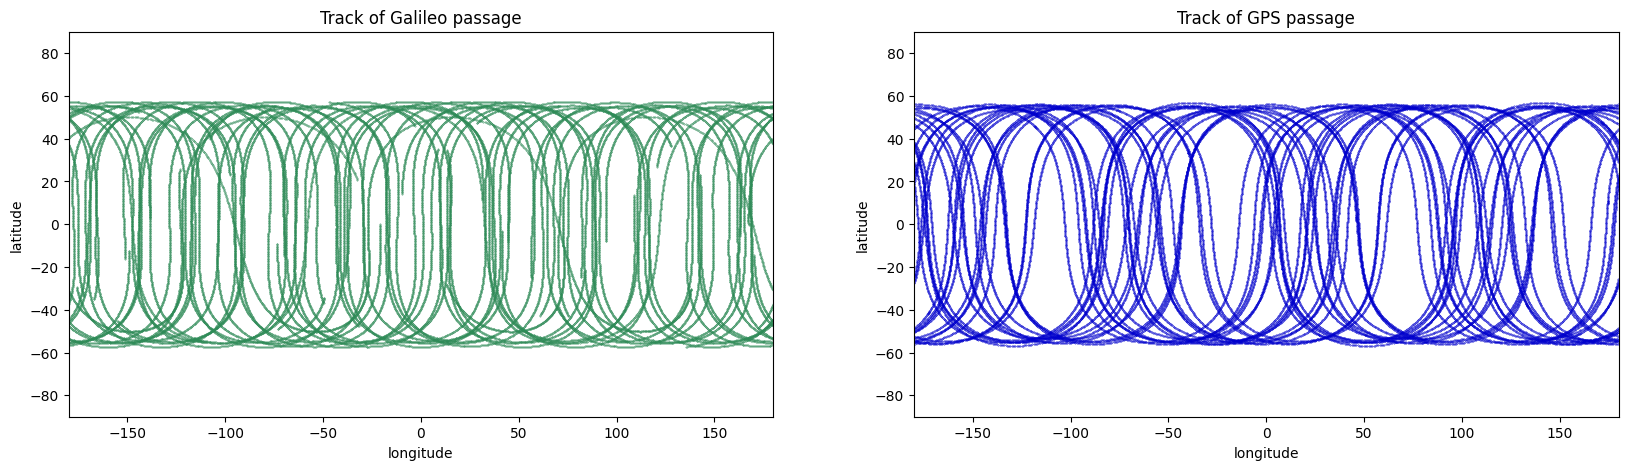

In [11]:
# Initialize 2D arrays to count satellite passages over Earth grid
earth_mid = np.zeros((180, 360), dtype=int)    # Counts for mid-level coverage (both constellations)
earth_extr = np.zeros((180, 360), dtype=int)   # Placeholder for extreme coverage (not used here)
earth_h_mid = np.zeros((180, 360), dtype=int)  # Placeholder for higher coverage (not used here)

# Lists to store latitude and longitude of satellite positions
coord_midgal = []  # Galileo satellites
coord_midgps = []  # GPS satellites
coord_extr1 = []   # Placeholder for extreme satellite coords
coord_extr2 = []   # Placeholder for extreme satellite coords

# Loop over Galileo satellites (assumed first 31)
for satellite in satellite_names[0:31]:    
    for t in range(len(df)):
        theta, phi = df.loc[t, 'Sph_'+satellite][0], df.loc[t, 'Sph_'+satellite][1]  # Extract lat and lon
        
        earth_mid[int(theta), int(phi)+180] += 1  # Increment Earth grid count (shift longitude by +180 to index 0–359)
        
        coord_midgal.append([theta, phi])  # Store coordinate for plotting

# Loop over GPS satellites (assumed next 31)
for satellite in satellite_names[31:62]:    
    for t in range(len(df)):
        theta, phi = df.loc[t, 'Sph_'+satellite][0], df.loc[t, 'Sph_'+satellite][1]
        
        earth_mid[int(theta), int(phi)+180] += 1  # Increment Earth grid count
        
        coord_midgps.append([theta, phi])  # Store coordinate for plotting

# Convert coordinate lists to NumPy arrays for easier plotting
coord_midgal = np.array(coord_midgal)
coord_midgps = np.array(coord_midgps)

# Plot the tracks of Galileo and GPS satellites
plt.figure(figsize=(20, 5))  # Set figure size

# Plot Galileo satellite tracks
plt.subplot(121)
plt.plot(coord_midgal[:, 1], coord_midgal[:, 0], color='seagreen', markersize=0.6, linestyle='', marker='.')  
plt.title('Track of Galileo passage')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xlim(-180, 180)
plt.ylim(-90, 90)

# Plot GPS satellite tracks
plt.subplot(122)
plt.plot(coord_midgps[:, 1], coord_midgps[:, 0], color='mediumblue', markersize=0.6, linestyle='', marker='.')
plt.title('Track of GPS passage')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xlim(-180, 180)
plt.ylim(-90, 90)


In [13]:
# Save the DataFrame containing satellite positions to a pickle file
import pickle

# Construct the filename dynamically using the time step (DT) and angular precision (precision_grad)
filename = f'DATI\\GALGPS_lowKp_positions_DT={DT}day_dgrad={precision_grad}.pkl'

# Open the file in write-binary mode and dump the DataFrame
with open(filename, 'wb') as file:
    pickle.dump(df, file)  # Serialize and save the DataFrame to disk


# ISL Extraction

In [14]:
# Load the previously saved satellite positions from the pickle file
import pickle

filename = f'DATI\\GALGPS_lowKp_positions_DT={DT}day_dgrad={precision_grad}.pkl'

with open(filename, 'rb') as file:
    satellite_data = pickle.load(file)  # Deserialize the DataFrame from disk

# Create a DataFrame from the loaded satellite data
df = pd.DataFrame(satellite_data)

# Print the number of rows in the DataFrame
print(len(df))

# Extract satellite names (assume columns 1 to 61 contain the satellites)
satellite_names = df.columns[1:62]
print(satellite_names)

# Display the first few rows of the DataFrame to inspect
df.head()


1534
Index(['GSAT0101 (GALILEO-PFM)', 'GSAT0102 (GALILEO-FM2)',
       'GSAT0103 (GALILEO-FM3)', 'GSAT0201 (GALILEO 5)',
       'GSAT0202 (GALILEO 6)', 'GSAT0203 (GALILEO 7)', 'GSAT0204 (GALILEO 8)',
       'GSAT0205 (GALILEO 9)', 'GSAT0206 (GALILEO 10)',
       'GSAT0209 (GALILEO 12)', 'GSAT0208 (GALILEO 11)',
       'GSAT0211 (GALILEO 14)', 'GSAT0210 (GALILEO 13)',
       'GSAT0207 (GALILEO 15)', 'GSAT0212 (GALILEO 16)',
       'GSAT0213 (GALILEO 17)', 'GSAT0214 (GALILEO 18)',
       'GSAT0215 (GALILEO 19)', 'GSAT0216 (GALILEO 20)',
       'GSAT0217 (GALILEO 21)', 'GSAT0218 (GALILEO 22)',
       'GSAT0221 (GALILEO 25)', 'GSAT0222 (GALILEO 26)',
       'GSAT0219 (GALILEO 23)', 'GSAT0220 (GALILEO 24)',
       'GSAT0223 (GALILEO 27)', 'GSAT0224 (GALILEO 28)',
       'GSAT0225 (GALILEO 29)', 'GSAT0227 (GALILEO 30)',
       'GSAT0226 (GALILEO 31)', 'GPS BIIR-2  (PRN 13)', 'GPS BIIR-4  (PRN 20)',
       'GPS BIIR-5  (PRN 22)', 'GPS BIIR-8  (PRN 16)', 'GPS BIIR-11 (PRN 19)',
       'GPS BII

,Time,GSAT0101 (GALILEO-PFM),GSAT0102 (GALILEO-FM2),GSAT0103 (GALILEO-FM3),GSAT0201 (GALILEO 5),GSAT0202 (GALILEO 6),GSAT0203 (GALILEO 7),GSAT0204 (GALILEO 8),GSAT0205 (GALILEO 9),GSAT0206 (GALILEO 10),...,Sph_GPS BIIF-10 (PRN 08),Sph_GPS BIIF-11 (PRN 10),Sph_GPS BIIF-12 (PRN 32),Sph_GPS BIII-1 (PRN 04),Sph_GPS BIII-2 (PRN 18),Sph_GPS BIII-3 (PRN 23),Sph_GPS BIII-4 (PRN 14),Sph_GPS BIII-5 (PRN 11),Sph_GPS BIII-6 (PRN 28),Sph_GPS BIII-7 (PRN 01)
0,2023-02-25T00:00:00Z,"[-23620.397042750552, -5433.239106947012, -169...","[-22085.488878885728, -19650.632052434376, 145...","[5612.995503457283, -18558.718954693577, -2236...","[-29883.934205838483, 6646.907459462488, -197....","[23087.36928755451, 5339.767107178452, -12539....","[11016.434970534665, -11817.233706994974, 2481...","[-19359.559382441996, 2661.3317009259404, -222...","[-17203.566398746083, 2066.7667118822837, 2398...","[10591.095901971394, 19005.924348291523, -2006...",...,"[-54.72714493236298, 64.06699489193454, 26616....","[-11.393153057813773, 110.83613621471756, 2630...","[51.89967925227061, 99.05220192899377, 26652.1...","[20.17283847358294, 0.24681853752444494, 26637...","[-42.01224810031754, -173.02705403607382, 2664...","[-37.41969787580755, 132.9022515239139, 26466....","[-29.52754718914317, -50.726237050551134, 2645...","[17.310397004416505, -121.34209072637475, 2660...","[47.780528975231036, 171.03941864101705, 26556...","[3.5782072982148523, 45.90861765883924, 26568...."
1,2023-02-25T00:00:56Z,"[-23698.55853509551, -5489.1049516793555, -168...","[-22084.869945232622, -19637.76476349226, 1626...","[5731.11543672835, -18603.07262622664, -22301....","[-29859.61783654104, 6644.320912869648, -49.92...","[23033.56723879762, 5390.503194747414, -12688....","[11124.504350062984, -11727.783896296982, 2480...","[-19458.756414199765, 2584.111798225108, -2215...","[-17178.680074970507, 1933.3189425868434, 2401...","[10573.244597890007, 19117.62551035771, -19972...",...,"[-54.77800892787753, 64.63912190548214, 26614....","[-11.787149167450176, 110.8802695242719, 26308...","[51.729035903560465, 99.52090827089036, 26650....","[20.54337959721423, 0.3164442430960854, 26637....","[-41.7035136051802, -172.7907369271538, 26647....","[-37.7533306255071, 133.0919298372256, 26467.3...","[-29.87892709286086, -50.594680625923665, 2645...","[17.687808067789806, -121.28521028046518, 2660...","[47.53234194946979, 171.39820616800947, 26556....","[3.1925931812009236, 45.94330322049513, 26568...."
2,2023-02-25T00:01:53Z,"[-23776.419853263433, -5544.154798290875, -167...","[-22083.43793851518, -19624.279173555897, 1799...","[5848.686711649559, -18647.801410153348, -2223...","[-29834.50854463976, 6641.3497979648255, 97.55...","[22979.06528717527, 5441.422667171935, -12836....","[11232.952180443384, -11638.849971022903, 2479...","[-19557.964143435944, 2507.6245009239915, -220...","[-17154.34246615172, 1799.607206026965, 24042....","[10555.971883256494, 19228.861236342625, -1987...",...,"[-54.82350439727278, 65.21330312234635, 26612....","[-12.180890404972214, 110.92521921109888, 2630...","[51.55419660723921, 99.98433431150532, 26649.1...","[20.913395487408927, 0.38756001059439454, 2663...","[-41.39288669502618, -172.55896876603418, 2664...","[-38.08540192269602, 133.2854226444752, 26468....","[-30.229266081492725, -50.460552684791466, 264...","[18.064784608745487, -121.22710092558313, 2660...","[47.28111580119659, 171.751360418813, 26556.44...","[2.806907231832284, 45.97778681247766, 26568.3..."
3,2023-02-25T00:02:49Z,"[-23853.971809181763, -5598.389394144899, -166...","[-22081.18785607935, -19610.182415741292, 1972...","[5965.702522498064, -18692.89934474236, -22164...","[-29808.606961886555, 6637.986961949065, 245.0...","[22923.873292015203, 5492.5301115491975, -1298...","[11341.770741701604, -11550.43783841154, 24790...","[-19657.173382898836, 2431.8722999317306, -219...","[-17130.556488584272, 1665.6402943043067, 2406...","[10539.274446889069, 19339.62323124429, -19776...",...,"[-54.86360

In [15]:
# Function to calculate the minimum distance (altitude) between a line segment and the origin
def altitude_link(pos1, pos2):
    # Extract coordinates of points P1 and P2
    x1, y1, z1 = pos1
    x2, y2, z2 = pos2
    
    # Vector from P1 to P2
    d = np.array([x2 - x1, y2 - y1, z2 - z1])
    P1 = np.array(pos1)
    
    # Cross product P1 x d (used to compute perpendicular distance)
    cross_product = np.cross(P1, d)

    # Parameter t along the line for the closest point to the origin
    t = - (x1 * d[0] + y1 * d[1] + z1 * d[2]) / (d[0]**2 + d[1]**2 + d[2]**2)
    
    # Compute the minimum distance from the line (P1-P2) to the origin
    distance = np.linalg.norm(cross_product) / np.linalg.norm(d)
    
    # Compute the coordinates of the point on the line closest to the origin
    closest_point = np.array([x1, y1, z1]) + t * d
    
    return closest_point, distance  # Return both the closest point and the minimum distance


In [16]:
# Calculate distances, midpoints, and minimum altitudes between all pairs of satellites

num_satellites = len(satellite_names)  # Total number of satellites
distances = np.zeros((len(df), num_satellites, num_satellites))  # 3D array to store pairwise distances at each time
midpoints = np.zeros((len(df), num_satellites, num_satellites, 3))  # Store midpoint coordinates
hmed = np.zeros((len(df), num_satellites, num_satellites))  # Store minimum altitudes along the line connecting satellites

k = 0
for t in range(len(df)):
    if t % 100 == 0:
        print(f'Distances calculated up to time {df.Time[t]}  iteration {t}')  # Progress report every 100 steps
        
    positions = df.loc[t, satellite_names].values  # Extract satellite positions at current time
    
    # Loop over all unique satellite pairs
    for i in range(num_satellites):
        for j in range(i + 1, num_satellites):
            
            # Compute Euclidean distance between satellites i and j
            distance = np.linalg.norm(np.array(positions[i]) - np.array(positions[j]))
            distances[t, i, j] = distances[t, j, i] = distance  # Symmetric assignment
            
            # Compute the midpoint and minimum altitude along the line connecting satellites
            res = altitude_link(positions[i], positions[j])
            midpoints[t, i, j] = midpoints[t, j, i] = res[0]  # Midpoint coordinates
            hmed[t, i, j] = hmed[t, j, i] = res[1] - Re     # Minimum altitude above Earth's surface

# Save the results as NumPy binary files for later use
np.save('DATI\\galgps_lowKp_hmed.npy', hmed)           # Minimum altitudes
np.save('DATI\\galgps_lowKp_midpoints.npy', midpoints) # Midpoint coordinates
np.save('DATI\\galgps_lowKp_distances.npy', distances) # Pairwise distances


Distances calculated up to time 2023-02-25T00:00:00Z  iteration 0
Distances calculated up to time 2023-02-25T01:33:53Z  iteration 100
Distances calculated up to time 2023-02-25T03:07:47Z  iteration 200
Distances calculated up to time 2023-02-25T04:41:40Z  iteration 300
Distances calculated up to time 2023-02-25T06:15:33Z  iteration 400
Distances calculated up to time 2023-02-25T07:49:27Z  iteration 500
Distances calculated up to time 2023-02-25T09:23:20Z  iteration 600
Distances calculated up to time 2023-02-25T10:57:13Z  iteration 700
Distances calculated up to time 2023-02-25T12:31:07Z  iteration 800
Distances calculated up to time 2023-02-25T14:05:00Z  iteration 900
Distances calculated up to time 2023-02-25T15:38:53Z  iteration 1000
Distances calculated up to time 2023-02-25T17:12:47Z  iteration 1100
Distances calculated up to time 2023-02-25T18:46:40Z  iteration 1200
Distances calculated up to time 2023-02-25T20:20:33Z  iteration 1300
Distances calculated up to time 2023-02-25T21:

In [52]:
distances = np.load('DATI\\galgps_lowKp_distances.npy')
midpoints = np.load('DATI\\galgps_lowKp_midpoints.npy')
hmed = np.load('DATI\\galgps_lowKp_hmed.npy')

In [17]:
h = 50  # Threshold altitude (unused in the condition, could be a placeholder)

couples = []  # Initialize list to store satellite pairs that meet altitude criteria

# Loop over all time steps
for t in range(len(df)):
    if t % 100 == 0:
        print(f'Pairs considered up to time {df.Time[t]}  iteration {t}')  # Progress report every 100 steps
    
    # Loop over all unique satellite pairs
    for i in range(num_satellites):
        for j in range(i + 1, num_satellites):
            
            # Check if the minimum altitude between the satellite pair is within the ionospheric layer
            if 0 <= hmed[t, i, j] <= Hion:
                # Store relevant information about the pair
                couple = [
                    t,                                # Time index
                    satellite_names[i],                # Name of first satellite
                    satellite_names[j],                # Name of second satellite
                    df.loc[t, satellite_names[i]],    # Position of first satellite [x, y, z]
                    df.loc[t, satellite_names[j]],    # Position of second satellite [x, y, z]
                    hmed[t, i, j],                     # Minimum altitude along the line connecting the satellites
                    midpoints[t, i, j]                 # Midpoint coordinates along the line
                ]
                couples.append(couple)  # Append the pair info to the list

df_isl = pd.DataFrame(couples, columns = ['time', 's1', 's2', 'r1', 'r2', 'h', 'rm'])
df_isl.head()

Pairs considered up to time 2023-02-25T00:00:00Z  iteration 0
Pairs considered up to time 2023-02-25T01:33:53Z  iteration 100
Pairs considered up to time 2023-02-25T03:07:47Z  iteration 200
Pairs considered up to time 2023-02-25T04:41:40Z  iteration 300
Pairs considered up to time 2023-02-25T06:15:33Z  iteration 400
Pairs considered up to time 2023-02-25T07:49:27Z  iteration 500
Pairs considered up to time 2023-02-25T09:23:20Z  iteration 600
Pairs considered up to time 2023-02-25T10:57:13Z  iteration 700
Pairs considered up to time 2023-02-25T12:31:07Z  iteration 800
Pairs considered up to time 2023-02-25T14:05:00Z  iteration 900
Pairs considered up to time 2023-02-25T15:38:53Z  iteration 1000
Pairs considered up to time 2023-02-25T17:12:47Z  iteration 1100
Pairs considered up to time 2023-02-25T18:46:40Z  iteration 1200
Pairs considered up to time 2023-02-25T20:20:33Z  iteration 1300
Pairs considered up to time 2023-02-25T21:54:27Z  iteration 1400
Pairs considered up to time 2023-02-2

,time,s1,s2,r1,r2,h,rm
0,0,GSAT0101 (GALILEO-PFM),GPS BIIF-6 (PRN 06),"[-23620.397042750552, -5433.239106947012, -169...","[14932.288898608982, -5114.624604114265, 21471...",648.661469,"[-3264.769799176982, -5265.012227400284, 3315...."
1,0,GSAT0101 (GALILEO-PFM),GPS BIIF-8 (PRN 03),"[-23620.397042750552, -5433.239106947012, -169...","[15580.112847713988, -6650.42982177204, 20272....",877.201288,"[-2826.210067500684, -6078.9065071755585, 2774..."
2,0,GSAT0103 (GALILEO-FM3),GPS BIIF-9 (PRN 26),"[5612.995503457283, -18558.718954693577, -2236...","[-11506.583846232203, 21210.16675039514, 10533...",150.985387,"[-3476.7118885717027, 2556.7259392755877, -489..."
3,0,GSAT0201 (GALILEO 5),GPS BIIF-7 (PRN 09),"[-29883.934205838483, 6646.907459462488, -197....","[24296.109292029843, 127.58111876518822, 10684...",133.491569,"[-757.250366067794, 3142.1786900725124, 5652.6..."
4,0,GSAT0202 (GALILEO 6),GSAT0205 (GALILEO 9),"[23087.36928755451, 5339.767107178452, -12539....","[-17203.566398746083, 2066.7667118822837, 2398...",905.561213,"[4005.7969654811423, 3789.691570604263, 4758.3..."


,time,s1,s2,r1,r2,h,rm
0,0,GSAT0101 (GALILEO-PFM),GPS BIIF-6 (PRN 06),"[-23620.39704247313, -5433.239108153095, -1699...","[14932.288898870142, -5114.6246033518055, 2147...",648.661469,"[-3264.769798908157, -5265.012227566986, 3315...."
1,0,GSAT0101 (GALILEO-PFM),GPS BIIF-8 (PRN 03),"[-23620.39704247313, -5433.239108153095, -1699...","[15580.112848053559, -6650.429820976481, 20272...",877.201288,"[-2826.210067190299, -6078.906507319856, 2774...."
2,0,GSAT0103 (GALILEO-FM3),GPS BIIF-9 (PRN 26),"[5612.995504404883, -18558.718954406973, -2236...","[-11506.58384731521, 21210.1667498076, 10533.3...",150.985387,"[-3476.7118887022634, 2556.7259390980616, -489..."
3,0,GSAT0201 (GALILEO 5),GPS BIIF-7 (PRN 09),"[-29883.934206177873, 6646.907457936617, -197....","[24296.109292023328, 127.58112000574985, 10684...",133.491569,"[-757.2503662282361, 3142.1786900338493, 5652...."
4,0,GSAT0202 (GALILEO 6),GSAT0205 (GALILEO 9),"[23087.36928728184, 5339.767108357318, -12539....","[-17203.56639885161, 2066.76671100383, 23985.4...",905.561213,"[4005.7969652876345, 3789.691570808793, 4758.3..."


In [18]:
# Reduce the DataFrame by sampling at most 2 links per satellite (s1) at each time step
df_reduced = (
    df_isl.groupby(['time', 's1'], group_keys=False)  # Group by time and the first satellite
          .apply(lambda g: g.loc[:, df_isl.columns]  # Select all columns
                            .sample(n=min(2, len(g)), random_state=None))  # Randomly sample up to 2 rows per group
          .reset_index(drop=True)  # Reset the index after sampling
)


# Construct the filename dynamically using the time step (DT) and angular precision (precision_grad)
filename = f'DATI\\GALGPS_lowKp_inter_satellite_DT={DT}day_dgrad={precision_grad}.pkl'

# Open the file in write-binary mode and dump the DataFrame
with open(filename, 'wb') as file:
    pickle.dump(df_reduced, file)  # Serialize and save the reduced DataFrame to disk

C:\Users\dange\AppData\Local\Temp\ipykernel_3888\1725229433.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[:, df_isl.columns]  # Select all columns


45018


In [63]:
with open('DATI\\GALGPS_hightKp_inter_satellite_DT='+ str(DT) +'day_dgrad=' + str(precision_grad)+ '.pkl', 'rb') as file:
    inter_satellite_data = pickle.load(file)

# Creazione del DataFrame
df_isl = pd.DataFrame(inter_satellite_data)
print(len(df_isl))
df_isl.head()

df_reducedh = (
    df_isl.groupby(['time', 's1'], group_keys=False)
          .apply(lambda g: g.loc[:, df_isl.columns].sample(n=min(2, len(g)), random_state=None))
          .reset_index(drop=True)
)

print(len(df_reducedh))
display(df_reducedh)

42906
41179


C:\Users\cadan\AppData\Local\Temp\ipykernel_1560\1156891999.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[:, df_isl.columns].sample(n=min(2, len(g)), random_state=None))


,time,s1,s2,r1,r2,h,rm
0,0,GPS BIIF-1 (PRN 25),GPS BIII-4 (PRN 14),"[-15729.010728541378, 5521.749530310229, 20283...","[14486.962886112924, -16966.59738665833, -1423...",123.169258,"[-685.0748959984921, -5674.753760080576, 3097...."
1,0,GPS BIIR-13 (PRN 02),GPS BIII-1 (PRN 04),"[-16233.170054867576, 4847.873385060633, -1987...","[24442.623916822446, 389.9797707956303, 10573....",350.273035,"[3891.0714039174673, 2642.3423128587383, -4811..."
2,0,GPS BIIR-8 (PRN 16),GPS BIIRM-8 (PRN 05),"[-1624.0706415963034, 25102.5650333353, -7942....","[191.46972257567057, -25993.243514737016, -526...",280.145611,"[-718.9258935570981, -371.45012313715415, -660..."
3,0,GPS BIIRM-1 (PRN 17),GPS BIIF-11 (PRN 10),"[17837.777736556982, -14443.362719039904, 1382...","[-9219.721257598194, 23697.8966812315, -6733.0...",867.891244,"[4173.635180817817, 4818.12208461157, 3445.200..."
4,0,GPS BIIRM-2 (PRN 31),GPS BIIRM-8 (PRN 05),"[8884.072471215668, 20926.10161366139, 13242.6...","[191.46972257567057, -25993.243514737016, -526...",171.655706,"[4556.417952549144, -2432.922355259292, 4027.1..."
...,...,...,...,...,...,...,...
41174,1533,GSAT0216 (GALILEO 20),GPS BIII-4 (PRN 14),"[-17024.603237779273, 5901.59894989386, 23490....","[14452.09689707194, -16590.117712176372, -1471...",467.771067,"[-349.5140801136622, -6013.607505744574, 3252...."
41175,1533,GSAT0217 (GALILEO 21),GSAT0224 (GALILEO 28),"[12687.300888495876, 16145.438549086477, -2131...","[-18544.419619912573, -21182.3388249097, 9166....",818.845558,"[-2924.8662399642726, -2514.0361583630984, -60..."
41176,1533,GSAT0223 (GALILEO 27),GPS BIIRM-1 (PRN 17),"[-8991.087367242579, 13210.710290292986, -2491...","[18176.07661840092, -14497.401588992443, 13305...",907.440168,"[5318.261773569095, -1383.5641478813268, -4783..."
41177,1533,GSAT0224 (GALILEO 28),GPS BIIRM-6 (PRN 07),"[-18544.419619912573, -21182.3388249097, 9166....","[22432.337373311566, 8100.64673624747, -11851....",405.341258,"[3094.997532825175, -5718.285870688398, -1932...."


In [64]:
with open('DATI\\GALGPS_hightKp_inter_satellite_DT='+ str(DT) +'day_dgrad=' + str(precision_grad)+ '.pkl', 'wb') as file:
    pickle.dump(df_reducedh, file)

# CREATION OF THE SYNTHETIC IONOSPHERE

In [19]:
# Convert spherical coordinates (latitude, longitude) to Cartesian coordinates
def cartesian(pos, R):
    lat, lon = pos                 # Extract latitude and longitude in degrees
    lat = lat * np.pi / 180        # Convert latitude to radians
    lon = lon * np.pi / 180        # Convert longitude to radians

    # Convert to Cartesian coordinates
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R * np.sin(lat)

    return [x, y, z]  # Return as list [x, y, z]


# Compute the angle gamma for a single solution
def gamma_def(alpha, Re=Re, Rs=Re+Hion):
    alpha = alpha * np.pi / 180        # Convert alpha to radians
    cosa2 = np.cos(alpha)**2           # Square of cosine of alpha
    A = Rs**2
    B = -2 * Re * Rs * (1 - cosa2)
    C = Re**2 - (Re**2 + Rs**2) * cosa2

    discriminant = B**2 - 4*A*C       # Quadratic discriminant

    # Compute two possible solutions for cos(gamma)
    cos_gamma1 = (-B - np.sqrt(discriminant)) / (2*A)
    cos_gamma2 = (-B + np.sqrt(discriminant)) / (2*A)

    # Choose the maximum solution
    cos_gamma = np.max([cos_gamma1, cos_gamma2])
    gamma = 180 * np.arccos(cos_gamma) / np.pi  # Convert back to degrees

    return gamma


# Compute both solutions for gamma
def gamma_12(alpha, Re=Re, Rs=Re+Hion):
    alpha = alpha * np.pi / 180        # Convert alpha to radians
    cosa2 = np.cos(alpha)**2
    A = Rs**2
    B = -2 * Re * Rs * (1 - cosa2)
    C = Re**2 - (Re**2 + Rs**2) * cosa2

    discriminant = B**2 - 4*A*C

    # Both possible solutions for cos(gamma)
    cos_gamma1 = (-B - np.sqrt(discriminant)) / (2*A)
    cos_gamma2 = (-B + np.sqrt(discriminant)) / (2*A)

    cos_gamma = [cos_gamma1, cos_gamma2]

    gamma = 180 * np.arccos(cos_gamma) / np.pi  # Convert both solutions to degrees

    return gamma


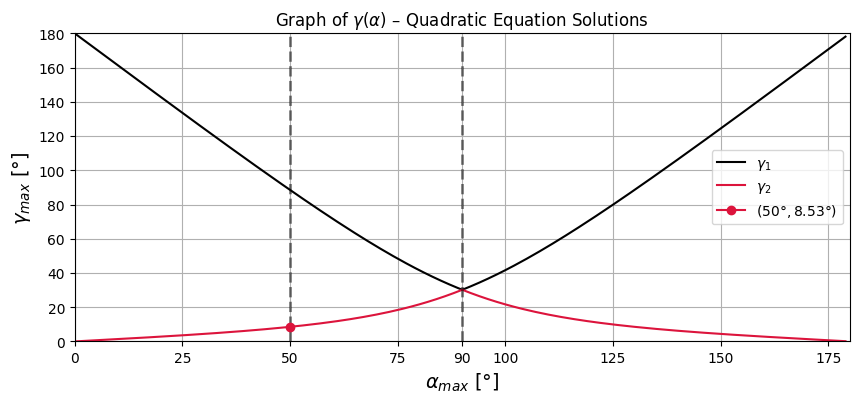

In [20]:
# The gamma function returns two solutions; let's plot both to see which is relevant

Rs = Re + Hion  # Radius of the ionospheric layer
alpha = np.arange(0, 180)  # Range of alpha angles in degrees

gamma1 = np.ones(len(alpha))  # Array to store first gamma solution
gamma2 = np.ones(len(alpha))  # Array to store second gamma solution

# Compute gamma1 and gamma2 for each alpha
for i in range(len(alpha)):
    a = alpha[i]
    gamma1[i], gamma2[i] = gamma_12(a, Re, Rs)  # Get both solutions

# Compute gamma for a specific alpha=50° using the single-solution function
gamma_max = gamma_def(50, Re=Re, Rs=Rs)

# Plot both solutions as functions of alpha
plt.figure(figsize=(10, 4))
plt.plot(alpha, gamma1, label=r'$\gamma_1$', color='k')       # First solution
plt.plot(alpha, gamma2, label=r'$\gamma_2$', color='crimson') # Second solution

# Add vertical dashed lines at alpha=50° and 90° for reference
plt.axvline(50, color='k', linestyle='dashed', linewidth=2, alpha=0.5)
plt.axvline(90, color='k', linestyle='dashed', linewidth=2, alpha=0.5)

# Highlight the gamma_max value for alpha=50°
plt.plot(50, gamma_max, marker='o', label=f'$(50°, {gamma_max:.2f}°)$', color='crimson')

plt.grid()
plt.title(r"Graph of $\gamma(\alpha)$ – Quadratic Equation Solutions")
plt.xlabel(r'$\alpha_{max}$ [°]', fontsize=14)
plt.ylabel(r'$\gamma_{max}$ [°]', fontsize=14)
plt.xlim(0, 180)
plt.ylim(0, 180)
plt.xticks([0, 25, 50, 75, 90, 100, 125, 150, 175])
plt.legend()
plt.show()


# Function to estimate the number of voxels above a given alpha
def number_of_voxels_per_alpha(alpha, Re=Re, Rs=Re+Hion):
    print(r, h)  # Debug print for current radius r and height h (must be defined in outer scope)
    gamma = gamma_def(alpha, Re=Re, Rs=Rs)  # Compute gamma for the given alpha
    print(gamma)  # Print gamma for debugging
    
    # The resulting number of voxels is estimated as the volume of a cone
    # with height Hion


In [21]:
h=50      # dimensione altezza voxels (km)
r=2       # dimensione larghezza e lunghezza voxels (gradi)

alpha_max = 50

lon0, lat0 = 0, 0
print(f'lon0, lat0 : {lon0, lat0}')
D = 10
gamma_max = gamma_def(alpha_max, Re, Re+Hion)
Dmin =  - D - int(gamma_max + r)
Dmax = + D + int(gamma_max + r)

lon_min = lon0 + Dmin
lon_max = lon0 + Dmax
lat_min = lat0 + Dmin
lat_max = lat0 + Dmax

print('gamma: ', gamma_max)
print('estremi lon:', lon_min, lon_max, 'estremi lat:', lat_min, lat_max, 'lato della regione:', lon_max-lon_min, lat_max-lat_min)

Dln = lon_max-lon_min 
Dlt = lat_max-lat_min 

Nlon = int(Dln/r)
Nlat = int(Dlt/r)
Nz = int((Hion - h)/h)
print('voxels per spigolo:', Nlon, Nlat, Nz)
print('numero di voxels nella regione:', Nlon * Nlat * Nz)

num_voxels = Nlat*Nlon*Nz

lon0, lat0 : (0, 0)
gamma:  8.530883915944756
estremi lon: -20 20 estremi lat: -20 20 lato della regione: 40 40
voxels per spigolo: 20 20 19
numero di voxels nella regione: 7600


# creation of a ionosphere 

3
[[-0.2567855   0.98191642 -0.14375967]
 [ 0.06486942 -0.84684354  0.94818899]
 [ 0.18321408  0.76024688  0.71646988]]
[[0.52711883 0.85187422 0.30300937]
 [0.65020069 0.57009673 0.32002586]
 [0.54592979 0.63590043 0.26829774]]


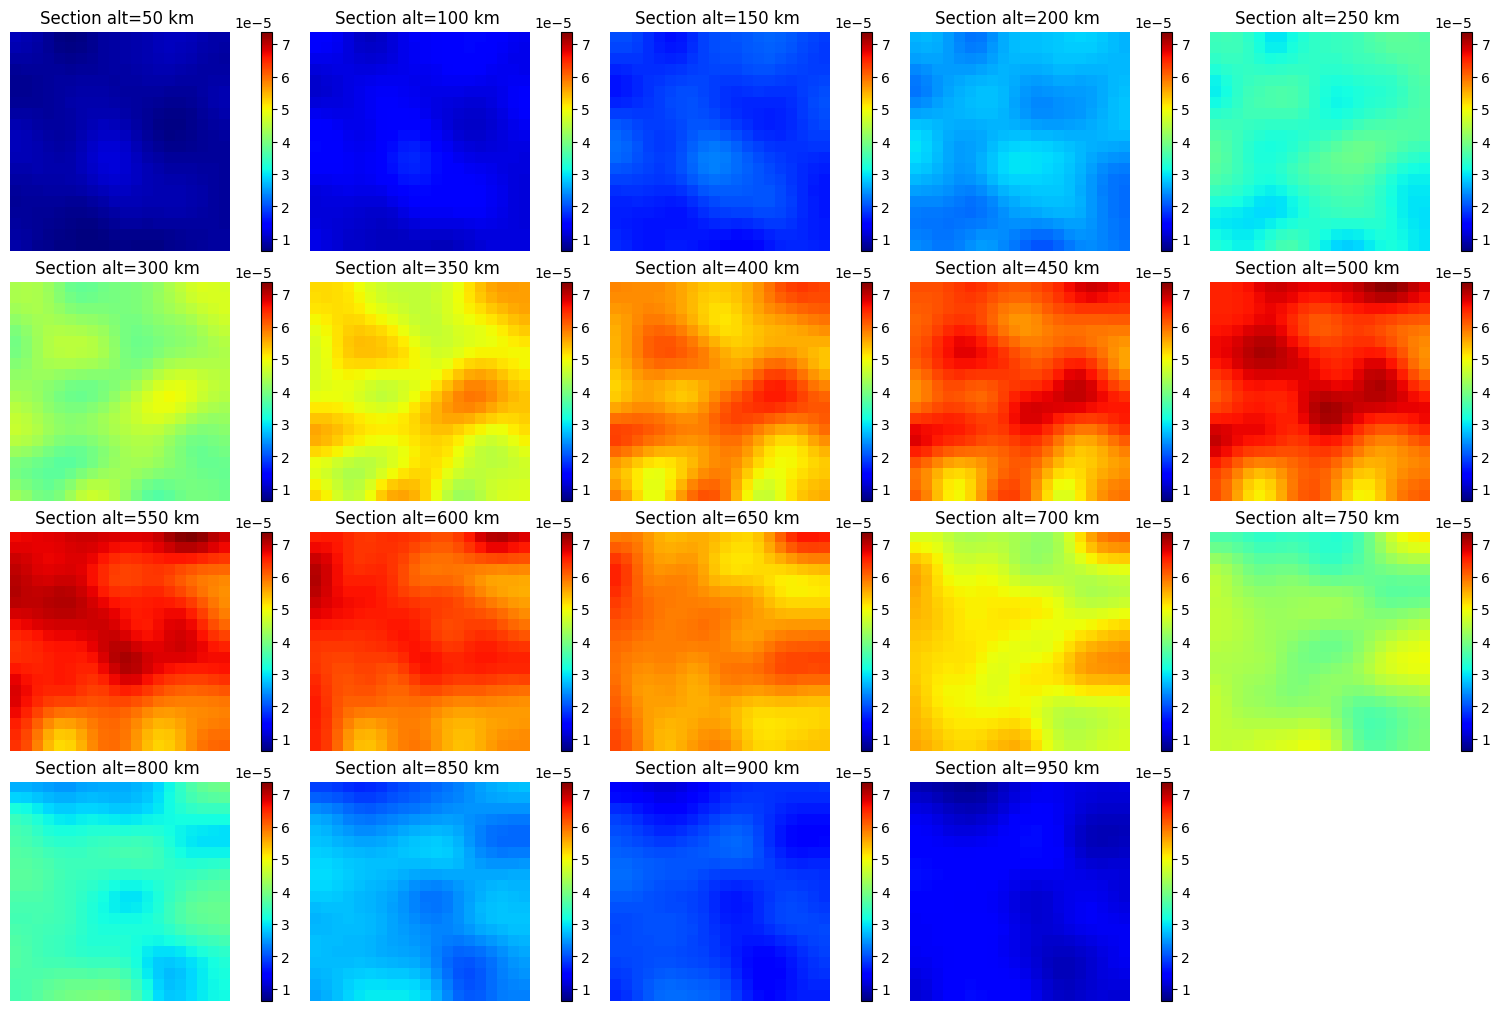

In [46]:
from scipy.ndimage import gaussian_filter
from scipy.stats import multivariate_normal
from scipy.stats import norm


x = np.linspace(-1, 1, Nlon)
y = np.linspace(-1, 1, Nlat)
z = np.linspace(-1, 1, Nz)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")


n_peaks = np.random.randint(3, 5)  # Tra 3 e 5 picchi

# Centri e varianze delle gaussiane
centers = np.random.uniform(-1, 1, size=(n_peaks, 3))
variances = np.random.uniform(0.2, 0.9, size=(n_peaks, 3))  # Varianze ampie

background = np.ones((Nlon, Nlat, Nz)) * 40
pos = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

print(n_peaks)
print(centers)
print(variances)
# Somma le gaussiane
for i in range(n_peaks):
    mean = centers[i]
    cov = np.diag(variances[i]**2)
    rv = multivariate_normal(mean, cov)
    values = rv.pdf(pos).reshape(Nlon, Nlat, Nz)
    background += (values*5)
    
noise_std = 3.5 # circa 75% di variabilità
raw_noise = np.random.normal(loc=0.0, scale=1.0, size=background.shape)
correlation_length = 2  # controlla la "smoothness"
smoothed_noise = gaussian_filter(raw_noise, sigma=correlation_length)

# Normalizza il rumore e scala alla deviazione standard desiderata
smoothed_noise -= np.mean(smoothed_noise)
smoothed_noise /= np.std(smoothed_noise)
smoothed_noise = smoothed_noise * noise_std
tec_field = background + smoothed_noise
tec_field = tec_field / (h * 1000) 


rtec_field = tec_field.copy()


m = 10
s = 5
x = np.linspace(0, 19, Nz)

pdf = norm.pdf(x, loc=m, scale=s)
for i, p in enumerate(pdf):
    rtec_field[:, :, i] = tec_field[:, :, i]*p
rtec_field = np.clip(rtec_field, 0, None)




cols = 5  # Numero di colonne
rows = int(np.ceil(Nz / cols))  # Numero di righe (calcolato automaticamente)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), constrained_layout=True)
# Troviamo il massimo valore per normalizzare tutte le colorbars
vmin, vmax = np.min(rtec_field), np.max(rtec_field)

# Ciclo per riempire i subplot
for i in range(Nz):
    row, col = divmod(i, cols)  # Trova la posizione nella griglia
    ax = axes[row, col]
    
    im = ax.imshow(rtec_field[:, :, i], cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(f"Section alt={i*50 + 50} km ")
    ax.axis("off")  # Nasconde gli assi per pulizia
    
    # Aggiunge una colorbar a ogni immagine
    fig.colorbar(im, ax=ax, fraction=0.05, pad=0.02)

# Rimuove subplot vuoti se il numero di sezioni non riempie la griglia
for j in range(Nz, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.show()

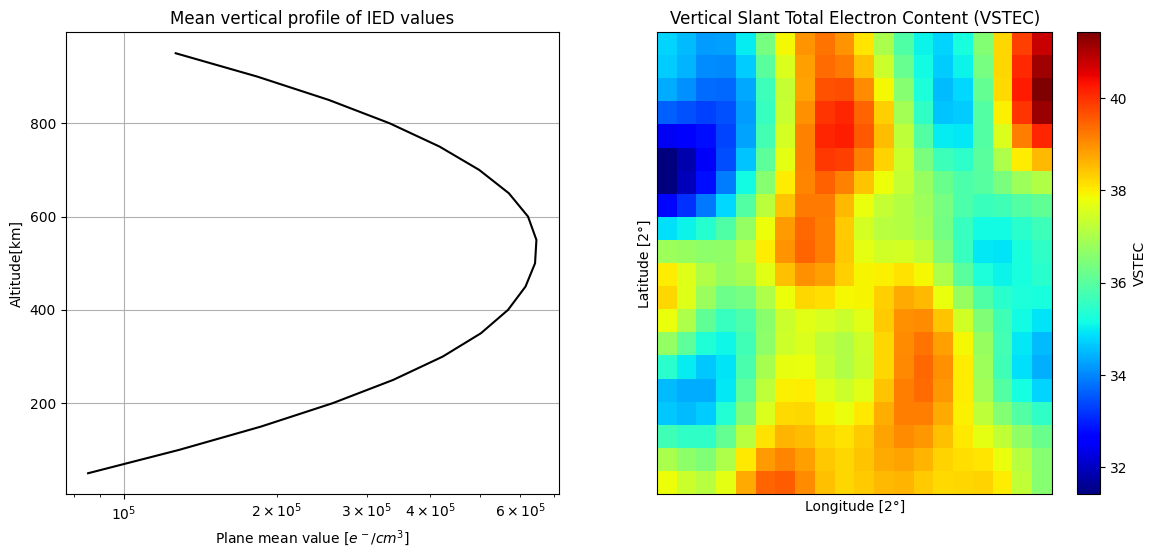

In [47]:
vmean=[]
x = np.arange(50, 1000, 50)
for i in range(Nz):
    vmean.append(np.mean(rtec_field[:, :, i]))

vmean=np.array(vmean) * 10**10
VSTEC = np.zeros((Nlon, Nlat))
for i in range(Nz):
    VSTEC += rtec_field[:, :, i]


plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.grid()
plt.xscale('log')
plt.plot(vmean, x, color='k')
plt.xlabel('Plane mean value [$e^- / cm^3$]')
plt.ylabel('Altitude[km]')
plt.title('Mean vertical profile of IED values')

plt.subplot(122)
plt.imshow(VSTEC.T * 50 *1000, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='jet')
plt.colorbar(label='VSTEC')
plt.title('Vertical Slant Total Electron Content (VSTEC)')
plt.xlabel('Longitude [2°]')
plt.ylabel('Latitude [2°]')
plt.xticks([])
plt.yticks([])

plt.show()


3.8910078785414795e-05
1.9184767647569915e-05


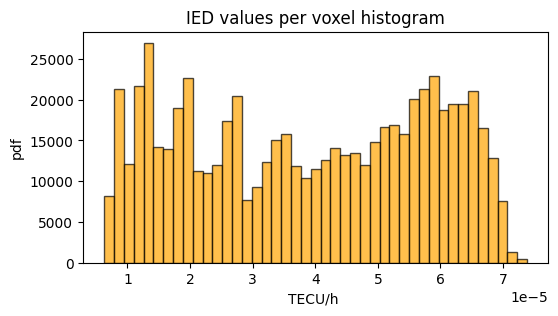

In [48]:
density_m = rtec_field.flatten()

m= np.mean(density_m)
s = np.std(density_m)

print(m)
print(s)
N=1
x = np.linspace(m - 4*s, m + 4*s, 100)
pdf = norm.pdf(x, loc=m, scale=s)

plt.figure(figsize= (6, 3))
plt.hist(density_m, bins=int(np.sqrt(len(density_m))/2), color='orange', edgecolor='black', density=True, alpha= 0.7)
#plt.plot(x, pdf, color='k', alpha= 0.7)

plt.xlabel('TECU/h ')
plt.ylabel('pdf')
plt.title('IED values per voxel histogram')

plt.show()

In [50]:
np.save('DATI\\flatten_simulated_ionosphere.npy', density_m)

# Ionosphere creation with IRI

In [85]:
h=50      # dimensione altezza voxels (km)
r=2       # dimensione larghezza e lunghezza voxels (gradi)

alpha_max = 50

lon0, lat0 = 10, 50
print(f'lon0, lat0 : {lon0, lat0}')
D = 10
gamma_max = gamma_def(alpha_max, Re, Re+Hion)
Dmin =  - D - int(gamma_max + r)
Dmax = + D + int(gamma_max + r)

lon_min = lon0 + Dmin
lon_max = lon0 + Dmax
lat_min = lat0 + Dmin
lat_max = lat0 + Dmax

print('gamma: ', gamma_max)
print('estremi lon:', lon_min, lon_max, 'estremi lat:', lat_min, lat_max, 'lato della regione:', lon_max-lon_min, lat_max-lat_min)

Dln = lon_max-lon_min 
Dlt = lat_max-lat_min 

Nlon = int(Dln/r)
Nlat = int(Dlt/r)
Nz = int((Hion - h)/h)
print('voxels per spigolo:', Nlon, Nlat, Nz)
print('numero di voxels nella regione:', Nlon * Nlat * Nz)

num_voxels = Nlat*Nlon*Nz

lon0, lat0 : (10, 50)
gamma:  8.530883915944756
estremi lon: -10 30 estremi lat: 30 70 lato della regione: 40 40
voxels per spigolo: 20 20 19
numero di voxels nella regione: 7600


In [ ]:
import PyIRI.edp_update as ml
import os 
import PyIRI
from pathlib import Path  # Better path handling across OS

# --- 1. Geographical Parameters ---
# Assumption: voxel grid spans roughly -20° to 20° latitude/longitude around some center
dlat, dlon, dalt = r, r, h  # Voxel sizes in lat, lon, and altitude
alt_min = h
alt_max = Hion

# --- 2. Temporal and Solar Parameters ---
anno = 2023
mese = 2
giorno = 25

# Request constant data at 12:00 UT
ahr = np.array([9.0])  # decimal hours (UT)

# Solar flux index F10.7 based on sunspot number (SSN)
SSN = 129
F107 = 63.7 + 0.728 * SSN + 0.00089 * (SSN**2)
print(F107)

# --- 3. Create Coordinate Vectors for the Voxel Grid ---
lat_vec = np.arange(lat_min + dlat/2, lat_max, dlat)  # Latitude centers
lon_vec = np.arange(lon_min + dlon/2, lon_max, dlon)  # Longitude centers
alt_vec = np.arange(alt_min + dalt/2, alt_max, dalt)  # Altitude centers

# Number of points in each dimension
num_lat = len(lat_vec)
num_lon = len(lon_vec)
num_alt = len(alt_vec)
num_temp = len(ahr)  # Should be 1
print('Grid dimensions:', num_lon, 'x', num_lat, 'x', num_alt, 'x', num_temp)

# Create a 2D meshgrid for horizontal coordinates (Lon x Lat)
LON_2D, LAT_2D = np.mgrid[lon_min+dlon/2 : lon_max : dlon, lat_min+dlat/2 : lat_max : dlat]

# Flatten horizontal coordinates for PyIRI input
alon = LON_2D.flatten()
alat = LAT_2D.flatten()
num_grid_punti = len(alon)
print(f"Horizontal points: {num_grid_punti} ({num_lon}x{num_lat})")
print(f"Altitude levels: {num_alt}")
print(f"Time points: {num_temp}")

# --- 4. PyIRI Coefficients Path ---
coeff_dir_path = "...PyIRI\\coefficients\\IGRF\\IGRF13.shc"
# Make sure path is correct
print("Starting PyIRI 3D calculation...")

# --- 5. Run PyIRI to get electron density profiles ---
f2, f1, e_peak, es_peak, sun, mag, edp = ml.IRI_density_1day(
    anno, mese, giorno, ahr, alon, alat, alt_vec, F107, 
    coeff_dir_path,  # Coefficients directory
    ccir_or_ursi=0   # Model option
)

print("Calculation completed.")

# --- 6. Reshape Results into a 3D Voxel Grid (Lon x Lat x Alt) ---

# 'edp' shape: (N_time, N_alt, N_grid_punti) -> (1, N_alt, N_lon*N_lat)
ne_alt_grid = edp[0, :, :]  # Remove time dimension (N_time=1)

# Transpose so that N_grid_punti is first dimension
ne_grid_alt = ne_alt_grid.T  # Shape: (N_lon*N_lat, N_alt)

# Reshape into (Lon x Lat x Alt)
densita_elettronica_voxel_moder = ne_grid_alt.reshape(num_lon, num_lat, num_alt)

# --- 7. Convert Units ---
fattore_conversione_m3__tecu_su_h = 5e-12  # Combined conversion factor to TECU per h
fattore_conversione_m3__cm3 = 1e-6        # Convert m^-3 to cm^-3

dalt_km = h  # voxel height in km

# Multiply array to get TECU and cm^-3
tec_tecusuh_moder = densita_elettronica_voxel_moder * dalt_km * fattore_conversione_m3__tecu_su_h
tec_esucm3_moder = densita_elettronica_voxel_moder * dalt_km * fattore_conversione_m3__cm3


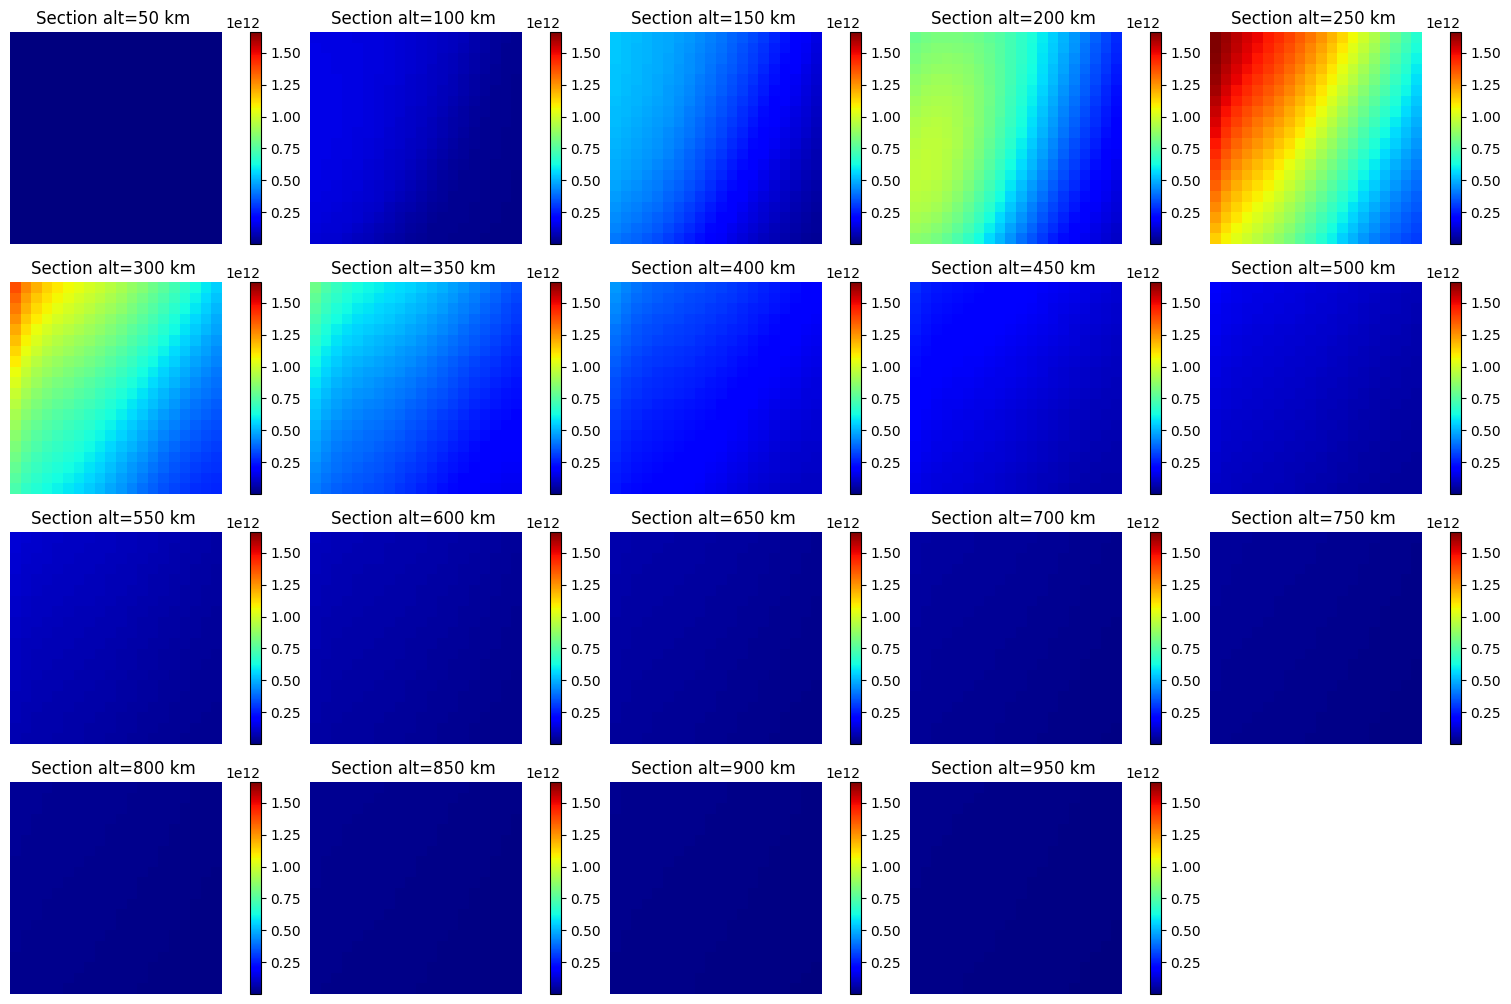

In [102]:
cols = 5  # Number of columns in the subplot grid
rows = int(np.ceil(Nz / cols))  # Compute number of rows automatically

# Create figure and axes with constrained layout for better spacing
fig, axes = plt.subplots(rows, cols, figsize=(15, 10), constrained_layout=True)

# Find global min and max for consistent color scaling across all slices
vmin, vmax = np.min(densita_elettronica_voxel_moder), np.max(densita_elettronica_voxel_moder)

# Loop over all altitude slices
for i in range(Nz):
    row, col = divmod(i, cols)  # Determine subplot row and column
    ax = axes[row, col]
    
    # Plot the 2D horizontal slice (Lon x Lat) at altitude index i
    im = ax.imshow(
        densita_elettronica_voxel_moder[:, :, i],  # Slice at current altitude
        cmap='jet',                                # Color map
        origin='lower',                            # Origin at lower-left
        vmin=vmin, vmax=vmax                       # Normalize colors globally
    )
    
    ax.set_title(f"Section alt={i*50 + 50} km ")  # Add altitude label
    ax.axis("off")  # Hide axes for cleaner visualization
    
    # Add a colorbar for each subplot
    fig.colorbar(im, ax=ax, fraction=0.05, pad=0.02)

# Remove empty subplots if Nz does not fill the entire grid
for j in range(Nz, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.show()


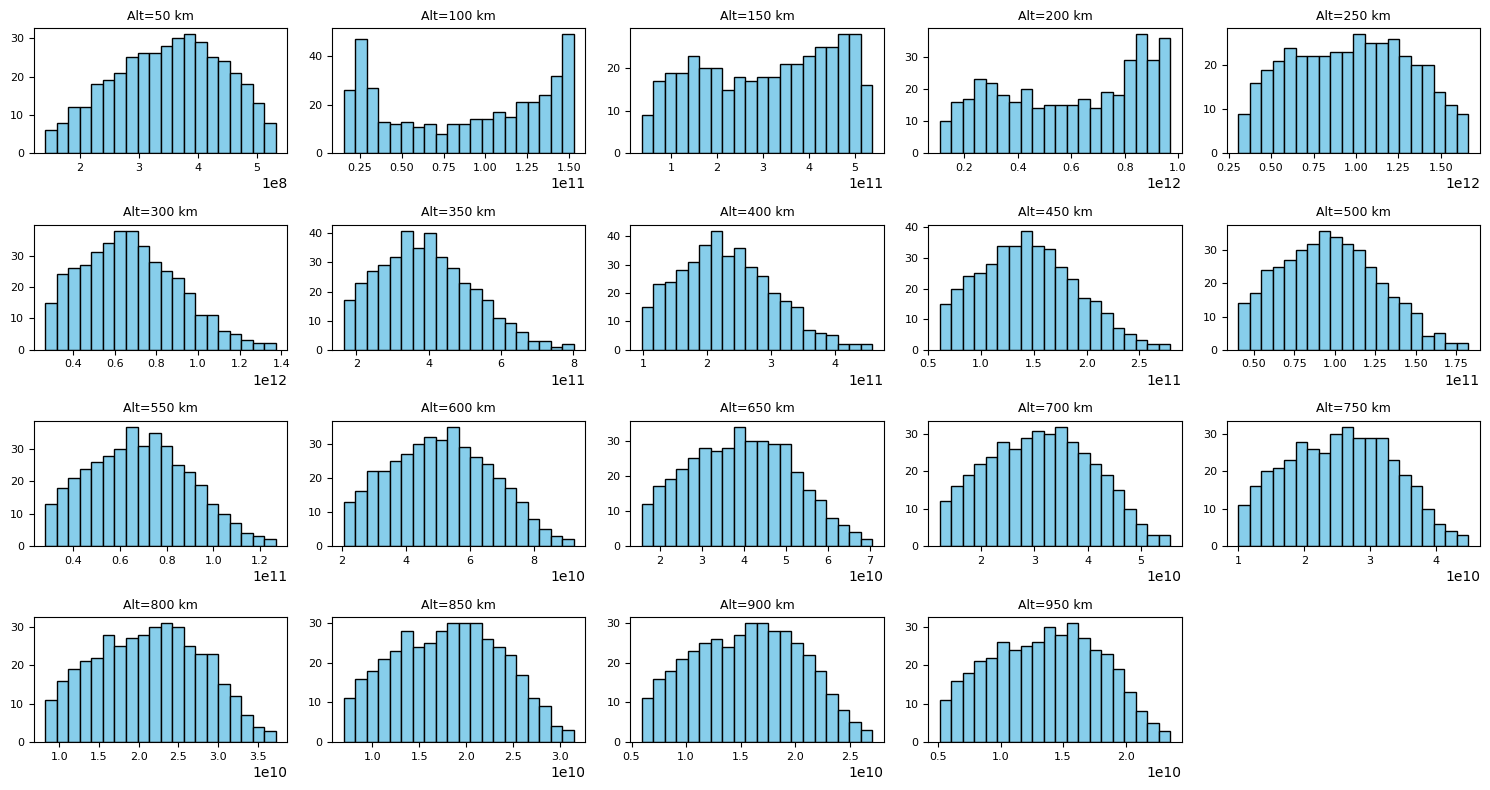

In [103]:
# Number of altitude slices in the voxel grid
Nz = densita_elettronica_voxel.shape[2]

# Flatten each horizontal slice (Lon x Lat) for histogram plotting
slice_vals_moder = [densita_elettronica_voxel_moder[:, :, i].flatten() for i in range(Nz)]

# --- 1. Create subplot grid for histograms ---
cols = 5  # Number of columns
rows = int(np.ceil(Nz / cols))  # Compute rows automatically

fig, axes = plt.subplots(rows, cols, figsize=(15, rows*2))
axes = axes.flatten()  # Flatten axes for easy indexing

# Plot histograms for each altitude slice
for i in range(Nz):
    ax = axes[i]
    ax.hist(slice_vals_moder[i], bins=20, color='skyblue', edgecolor='k')
    ax.set_title(f"Alt={i*50 + 50} km", fontsize=9)
    ax.tick_params(axis='both', which='both', labelsize=8)  # Smaller tick labels

# Hide unused axes if Nz is not a multiple of cols
for j in range(Nz, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# --- 2. Compute summary statistics for each altitude slice ---
vmean_moder = [np.mean(slice_vals_moder[i]) for i in range(Nz)]     # Mean
vmedian_moder = [np.median(slice_vals_moder[i]) for i in range(Nz)] # Median
vst_moder = [np.std(slice_vals_moder[i]) for i in range(Nz)]        # Standard deviation
v10_moder = [np.percentile(slice_vals_moder[i], 10) for i in range(Nz)]  # 10th percentile
v90_moder = [np.percentile(slice_vals_moder[i], 90) for i in range(Nz)]  # 90th percentile


# --- 3. Compute Vertical Slant Total Electron Content (VSTEC) ---
VSTEC = np.zeros((Nlon, Nlat))  # Initialize 2D array for horizontal map
for i in range(Nz):
    VSTEC += densita_elettronica_voxel_moder[:, :, i] * 50 * 1000  # Multiply by voxel height in meters


# --- 4. Plot vertical profile and VSTEC map ---
plt.figure(figsize=(14, 6))

# Left: vertical profile (median + 10-90 percentile)
plt.subplot(121)
plt.plot(vmedian_moder, x, label='Median', color='b')
plt.fill_betweenx(x, v10_moder, v90_moder, color='gray', alpha=0.3, label='10-90 percentile')
plt.xlabel('Electron density [$e^- / m^3$]')
plt.ylabel('Altitude [km]')
plt.title('Vertical profile: median and interquartile range')
plt.legend()
plt.grid()
plt.xscale('log')  # Electron density spans orders of magnitude

# Right: 2D horizontal map of VSTEC
plt.subplot(122)
plt.imshow(VSTEC.T * 1e-16, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='jet')
plt.colorbar(label='VSTEC')
plt.title('Vertical Slant Total Electron Content (VSTEC) [TECU]')
plt.xlabel('Longitude [2°]')
plt.ylabel('Latitude [2°]')
plt.xticks([])
plt.yticks([])

plt.show()


In [131]:
density_m = densita_elettronica_voxel_moder.flatten()
np.save('DATI\\flatten_iri_moderateionosphere.npy', density_m)

[ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900
 950]


In [107]:
# Parametri Geografici (Assunzione: -20° a 20° per un'estensione di 40°)
dlat, dlon, dalt = r, r, h
alt_min = h
alt_max = Hion
# Parametri Temporali e Solari
anno = 2023
mese = 2
giorno = 27

# Richiesta: dati costanti riferiti alle 12:00 UT
# Creiamo un array temporale di un solo elemento (12.0 ore decimali)
ahr = np.array([9.0]) 

# Indice F10.7 (importante per l'attività solare del 2025)

SSN =192
F107= 63.7+ 0.728 * SSN + 0.00089 * (SSN**2)
print(F107)

# --- 2. Creazione dei Vettori di Coordinate e Appiattimento ---

# Vettori 1D per i centri dei voxel
lat_vec = np.arange(lat_min+dlat/2, lat_max, dlat)
lon_vec = np.arange(lon_min+dlon/2, lon_max, dlon)
alt_vec = np.arange(alt_min+dalt/2, alt_max, dalt)

# Numero di punti per dimensione
num_lat = len(lat_vec)
num_lon = len(lon_vec)
num_alt = len(alt_vec)
num_temp = len(ahr) # Dovrebbe essere 1
print('Dimensioni griglia costruita:', num_lon, 'x', num_lat, 'x', num_alt, 'x', num_temp)

# meshgrid per creare la griglia completa (Lon x Lat)
LON_2D, LAT_2D = np.mgrid[lon_min+dlon/2:lon_max: dlon, lat_min+dlat/2:lat_max:dlat]

# Appiattimento delle coordinate orizzontali in array 1D
alon = LON_2D.flatten()
alat = LAT_2D.flatten()
num_grid_punti = len(alon)

print(f"Punti orizzontali: {num_grid_punti} ({num_lon}x{num_lat})")
print(f"Livelli di altitudine: {num_alt}")
print(f"Punti temporali: {num_temp}")

coeff_dir_path = os.path.dirname(os.path.abspath(PyIRI.__file__))
coeff_dir_path = str(coeff_dir_path) + '\coefficients'


print("\nInizio calcolo PyIRI 3D...")

f2, f1, e_peak, es_peak, sun, mag, edp = ml.IRI_density_1day(
    anno, mese, giorno, ahr, alon, alat, alt_vec, f107, 
    coeff_dir_path, # Passiamo il percorso corretto come stringa
    ccir_or_ursi=0
)

print("Calcolo completato.")

# --- 4. Rimodellamento del Risultato in una Griglia Voxel (Lon x Lat x Alt) ---

# Forma attuale di 'edp': (N_time, N_alt, N_grid_punti)
# Con N_time = 1, la forma è (1, N_alt, N_lon * N_lat)

# 4.1 Rimuovi la dimensione temporale (N_time=1)
ne_alt_grid = edp[0, :, :] # Forma (N_alt, N_lon * N_lat)

# 4.2 Riorganizza per avere (N_lon * N_lat, N_alt) per il reshape finale
# Trasponi per avere N_grid_punti come prima dimensione
ne_grid_alt = ne_alt_grid.T # Forma (N_lon * N_lat, N_alt)

# 4.3 Rimodella nell'ordine Lon x Lat x Alt
densita_elettronica_voxel_storm = ne_grid_alt.reshape(num_lon, num_lat, num_alt)

# Fattore di conversione combinato: (1000 m/km) * (10^-16 TECU/(e-/m^2)) = 10^-13
fattore_conversione_m3__tecu_su_h = 5*1e-12
fattore_conversione_m3__cm3 = 1e-6

dalt_km=h
# Moltiplica tutti gli elementi dell'array:
tec_tecusuh = densita_elettronica_voxel_storm * dalt_km * fattore_conversione_m3__tecu_su_h
tec_esucm3 = densita_elettronica_voxel_storm * dalt_km * fattore_conversione_m3__cm3

236.28496
Dimensioni griglia costruita: 20 x 20 x 19 x 1
Punti orizzontali: 400 (20x20)
Livelli di altitudine: 19
Punti temporali: 1

Inizio calcolo PyIRI 3D...
Calcolo completato.


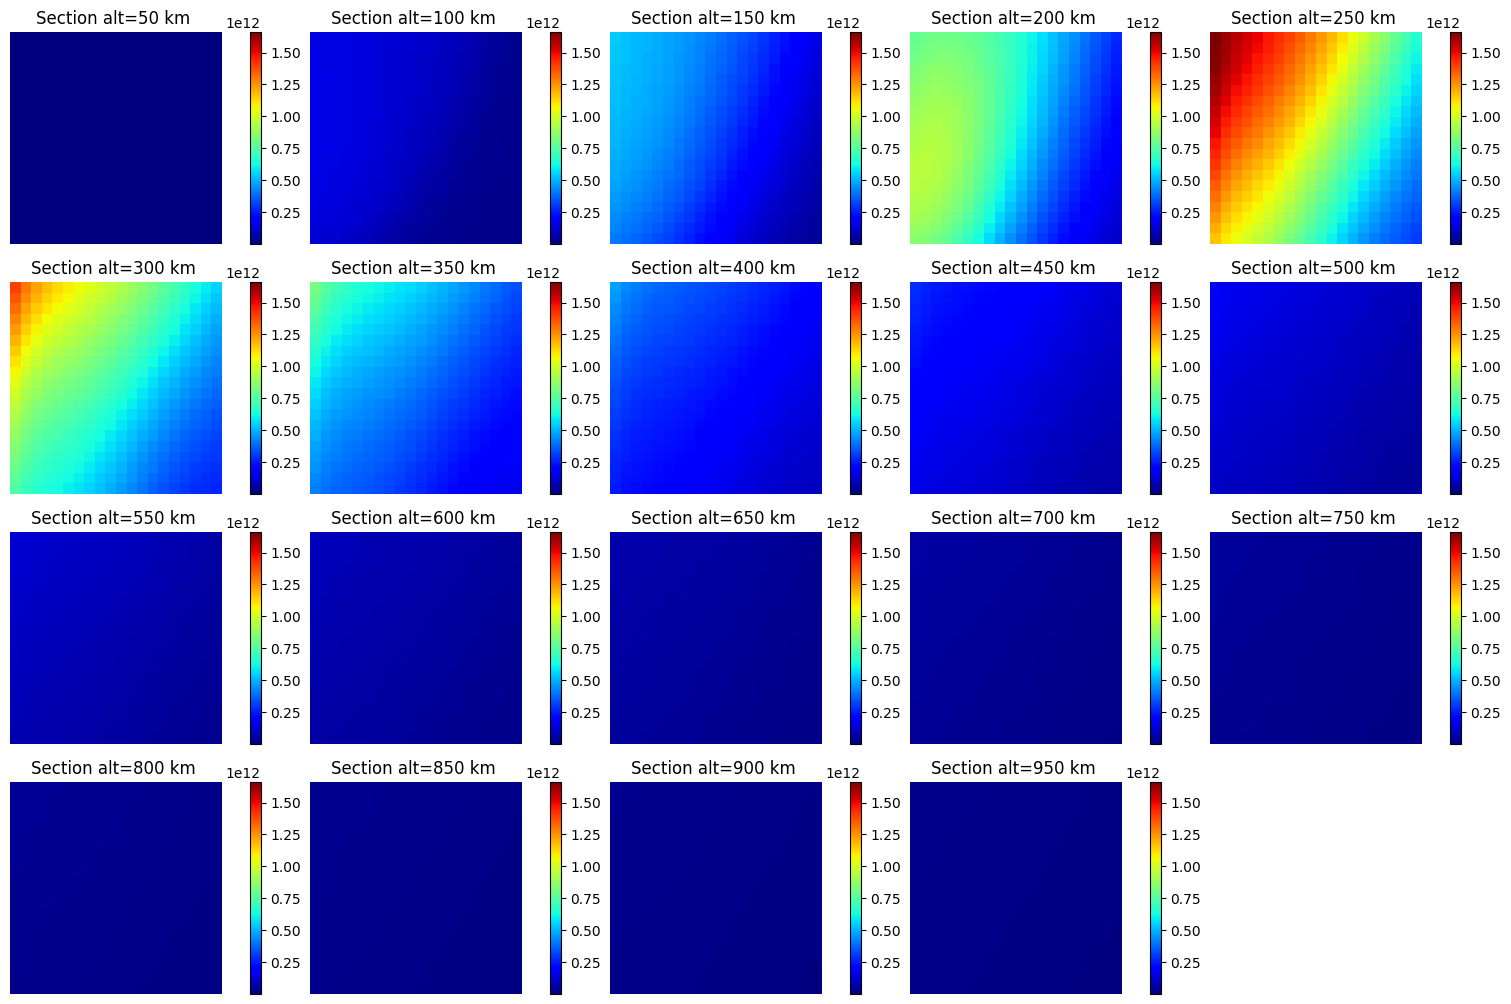

In [108]:
cols = 5  # Numero di colonne
rows = int(np.ceil(Nz / cols))  # Numero di righe (calcolato automaticamente)

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), constrained_layout=True)
# Troviamo il massimo valore per normalizzare tutte le colorbars
vmin, vmax = np.min(densita_elettronica_voxel_storm), np.max(densita_elettronica_voxel_storm)

# Ciclo per riempire i subplot
for i in range(Nz):
    row, col = divmod(i, cols)  # Trova la posizione nella griglia
    ax = axes[row, col]
    
    im = ax.imshow(densita_elettronica_voxel_storm[:, :, i], cmap='jet', origin='lower', vmin=vmin, vmax=vmax)
    ax.set_title(f"Section alt={i*50 + 50} km ")
    ax.axis("off")  # Nasconde gli assi per pulizia
    
    # Aggiunge una colorbar a ogni immagine
    fig.colorbar(im, ax=ax, fraction=0.05, pad=0.02)

# Rimuove subplot vuoti se il numero di sezioni non riempie la griglia
for j in range(Nz, rows * cols):
    fig.delaxes(axes.flatten()[j])

plt.show()

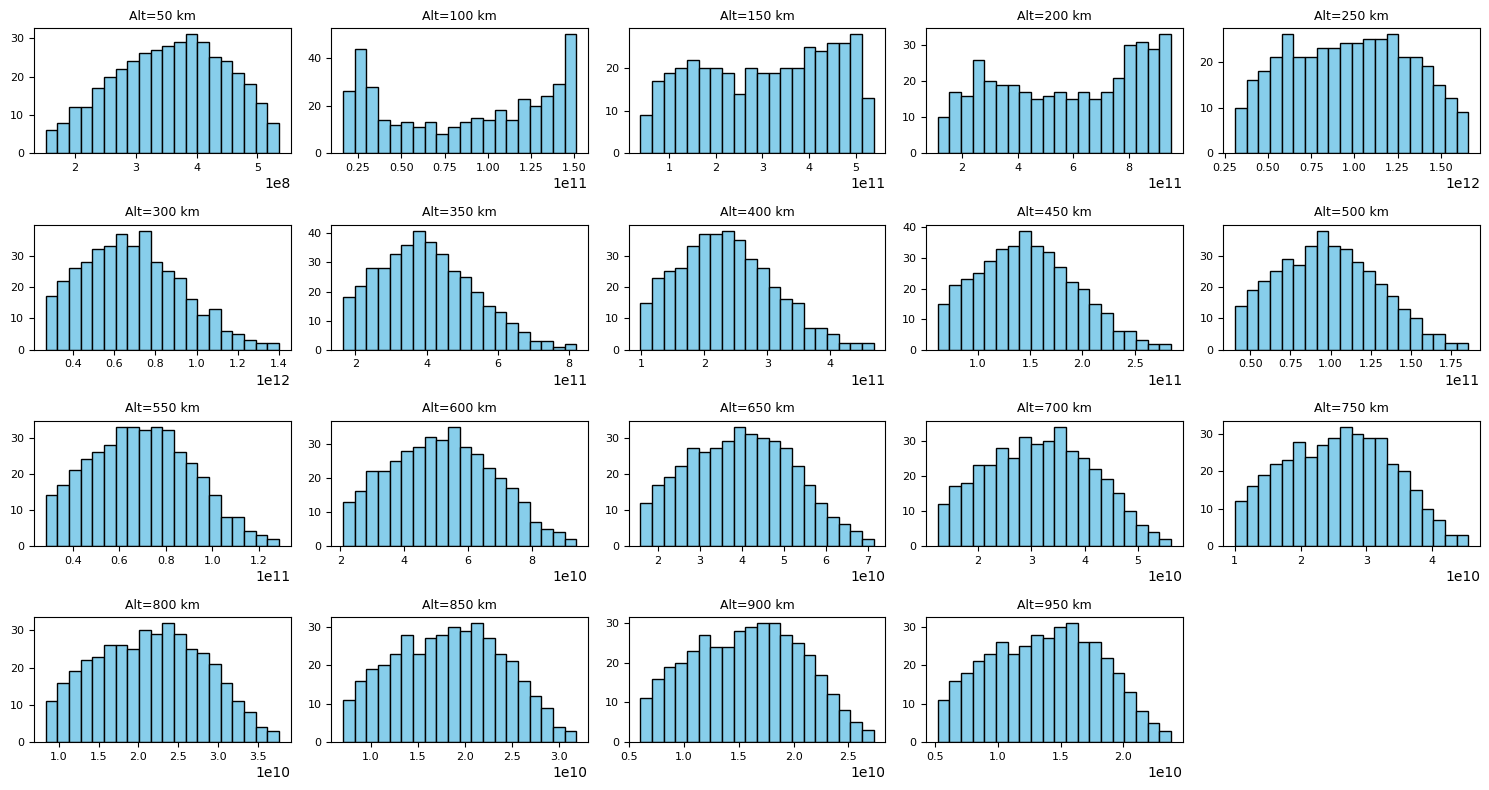

In [109]:
Nz = densita_elettronica_voxel.shape[2]
slice_vals_storm = [densita_elettronica_voxel_storm[:, :, i].flatten() for i in range(Nz)]

# Griglia di subplot
cols = 5  # numero di colonne nella griglia
rows = int(np.ceil(Nz / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, rows*2))
axes = axes.flatten()  # rende più semplice l'indicizzazione

# Crea istogrammi
for i in range(Nz):
    ax = axes[i]
    ax.hist(slice_vals_storm[i], bins=20, color='skyblue', edgecolor='k')
    ax.set_title(f"Alt={i*50 + 50} km", fontsize=9)
    ax.tick_params(axis='both', which='both', labelsize=8)  # etichette più piccole

# Nasconde gli assi inutilizzati se Nz non è multiplo di cols
for j in range(Nz, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

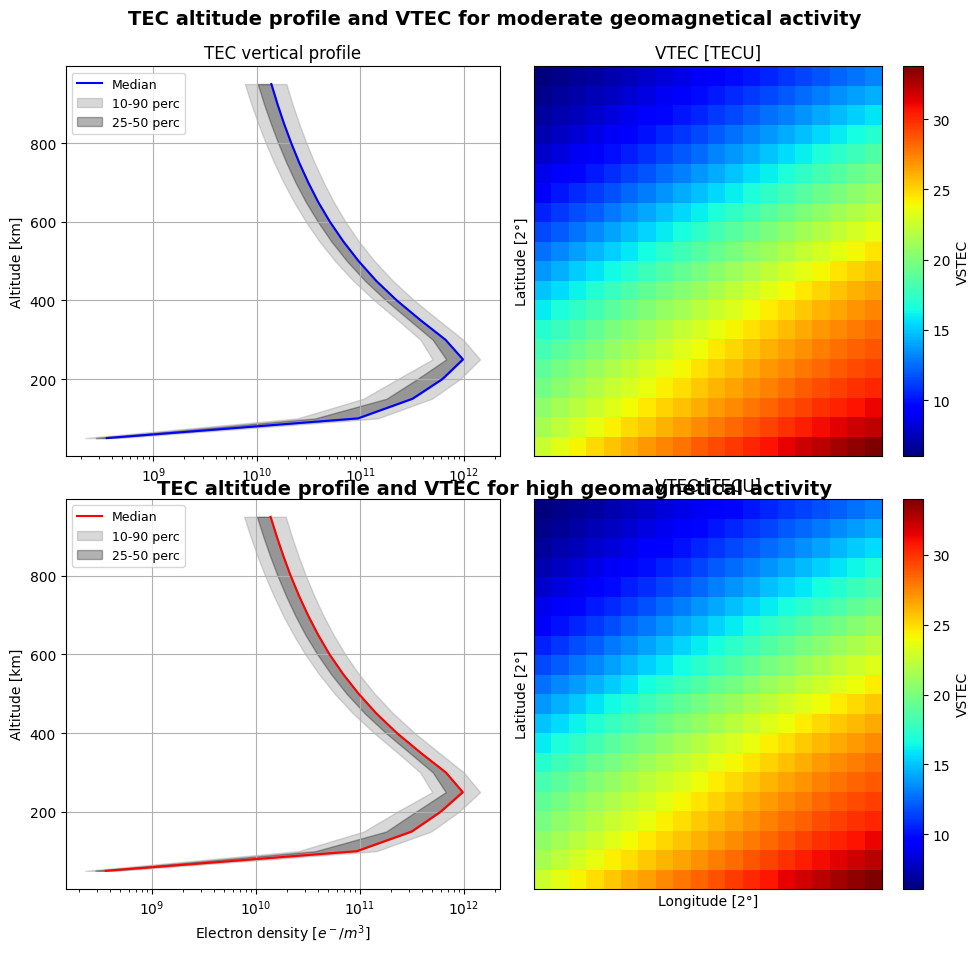

In [123]:
vmean_moder = [np.mean(slice_vals_moder[i]) for i in range(Nz)]
vmedian_moder = [np.median(slice_vals_moder[i]) for i in range(Nz)]
vst_moder = [np.std(slice_vals_moder[i]) for i in range(Nz)]

v10_moder = [np.percentile(slice_vals_moder[i], 10) for i in range(Nz)]
v90_moder = [np.percentile(slice_vals_moder[i], 90) for i in range(Nz)]
v25_moder = [np.percentile(slice_vals_moder[i], 25) for i in range(Nz)]
v50_moder = [np.percentile(slice_vals_moder[i], 50) for i in range(Nz)]

vmean_storm = [np.mean(slice_vals_storm[i]) for i in range(Nz)]
vmedian_storm = [np.median(slice_vals_storm[i]) for i in range(Nz)]
vst_storm = [np.std(slice_vals_storm[i]) for i in range(Nz)]

v10_storm = [np.percentile(slice_vals_storm[i], 10) for i in range(Nz)]
v90_storm = [np.percentile(slice_vals_storm[i], 90) for i in range(Nz)]
v25_storm = [np.percentile(slice_vals_storm[i], 25) for i in range(Nz)]
v50_storm = [np.percentile(slice_vals_storm[i], 50) for i in range(Nz)]


VSTEC_moder = np.zeros((Nlon, Nlat))
for i in range(Nz):
    VSTEC_moder += densita_elettronica_voxel_moder[:, :, i] * h * 1000

VSTEC_storm = np.zeros((Nlon, Nlat))
for i in range(Nz):
    VSTEC_storm += densita_elettronica_voxel_storm[:, :, i] * h * 1000


plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.plot(vmedian_moder, x, label='Median', color='b')
plt.fill_betweenx(x, v10_moder, v90_moder, color='gray', alpha=0.3, label='10-90 perc')
plt.fill_betweenx(x, v25_moder, v50_moder, color='k', alpha=0.3, label='25-50 perc')
plt.ylabel('Altitude [km]')
plt.title('TEC vertical profile')
plt.legend(loc='upper left', fontsize=9)
plt.grid()
plt.xscale('log')

plt.subplot(222)
plt.imshow(VSTEC_moder.T * 1e-16, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='jet')
plt.colorbar(label='VSTEC')
plt.title('VTEC [TECU]')
#plt.xlabel('Longitude [2°]')
plt.ylabel('Latitude [2°]')
plt.xticks([])
plt.yticks([])

plt.subplot(223)
plt.plot(vmedian_storm, x, label='Median', color='r')
plt.fill_betweenx(x, v10_storm, v90_storm, color='gray', alpha=0.3, label='10-90 perc')
plt.fill_betweenx(x, v25_storm, v50_storm, color='k', alpha=0.3, label='25-50 perc')

plt.xlabel('Electron density [$e^- / m^3$]')
plt.ylabel('Altitude [km]')
#plt.title('TEC vertical profile')
plt.legend(loc='upper left', fontsize=9)
plt.grid()
plt.xscale('log')

plt.subplot(224)
plt.imshow(VSTEC_storm.T * 1e-16, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='jet')
plt.colorbar(label='VSTEC')
plt.title('VTEC [TECU]')
plt.xlabel('Longitude [2°]')
plt.ylabel('Latitude [2°]')
plt.xticks([])
plt.yticks([])

plt.figtext(0.5, 0.95, 'TEC altitude profile and VTEC for moderate geomagnetical activity',
            ha='center', va='top', fontsize=14, fontweight='bold')
plt.figtext(0.5, 0.48, 'TEC altitude profile and VTEC for high geomagnetical activity',
            ha='center', va='top', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.93]) 

plt.show()

In [ ]:
density_m = densita_elettronica_voxel_storm.flatten()
np.save('DATI\\flatten_iri_highionosphere.npy', density_m)